## This code is used to generate water map by using pretrained SWatNet

In [1]:
import sys
sys.path.append("../")
import tensorflow as tf
from utils.tiff_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.imgPatch import imgPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

In [2]:
# sen1 images
root_dir = '/home/yons/Desktop/developer-luo/SWatNet'
scene_num = 'scene20'
path_s1_ascend = root_dir + '/data/s1_ascend/' + scene_num+ '_s1_ascend.tif'
path_s1_descend = root_dir + '/data/s1_descend/' + scene_num+ '_s1_descend.tif'
path_water_map = root_dir + '/data/s2_img_truth/'+ scene_num + '_wat_truth.tif'
s1_ascend, geotrans_s1, proj_s1, row_s1, col_s1, bands_s1 = readTiff(path_in=path_s1_ascend)
s1_descend, _, _, _, _, _ = readTiff(path_in=path_s1_descend)
s1_img = np.concatenate((s1_ascend, s1_descend), axis=2)
truth_map, _, _, _, _, _ = readTiff(path_in=path_water_map)
print(s1_img.shape)


(3216, 3590, 4)


### Visulize the s1 image and the water truth.

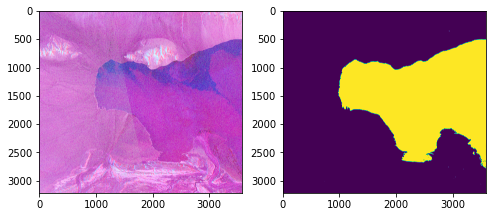

In [3]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imgShow(s1_img)
plt.subplot(1,2,2)
imgShow(truth_map)


### Load the pretrained model

In [4]:
# weight_path = root_dir + '/models/temporal/unet_gru_triple/weights_epoch_31'
path_model = root_dir + '/models/pretrained/unet_gru_triple'
# with tf.device('/device:gpu:0'):
model = tf.keras.models.load_model(path_model)  ## load model
# model.load_weights(weight_path)
# model.summary()


#### Data normalization

In [5]:
s1_img_nor = s1_img.copy()
s1_img_nor[:,:,0:2] = (s1_img[:,:,0:2]-np.nanmin(s1_img[:,:,0:2]))/(np.nanmax(s1_img[:,:,0:2])-np.nanmin(s1_img[:,:,0:2]))
s1_img_nor[:,:,2:] = (s1_img[:,:,2:]-np.nanmin(s1_img[:,:,2:]))/(np.nanmax(s1_img[:,:,2:])-np.nanmin(s1_img[:,:,2:]))
s1_img_nor = np.float32(s1_img_nor)
# s1_img_nor

#### Convert remote sensing image to multi-scale patches

In [6]:
imgPat_ins = imgPatch(img=s1_img_nor, patch_size=256, edge_overlay = 60)
patch_list, start_list,img_patch_row, img_patch_col = imgPat_ins.toPatch()
mid_patch_list = imgPat_ins.higher_patch_crop(higher_patch_size=512, start_list=start_list)
higher_patch_list = imgPat_ins.higher_patch_crop(higher_patch_size=2048, start_list=start_list)
'''Resize multi-scale patches to the same size'''
mid2low_patch_list = [scipy.ndimage.zoom(input=patch, zoom=(1/2, 1/2, 1), order=0) for patch in mid_patch_list]
higher2low_patch_list = [scipy.ndimage.zoom(input=patch, zoom=(1/8, 1/8, 1), order=0) for patch in higher_patch_list]

print(patch_list[0].shape, mid_patch_list[0].shape, higher_patch_list[0].shape)
print(len(patch_list),len(mid_patch_list),len(higher_patch_list))


(256, 256, 4) (512, 512, 4) (2048, 2048, 4)
323 323 323


#### Check the multi-scale patches

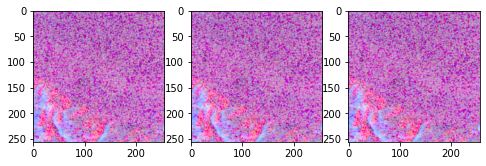

In [7]:
ind = 254
plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
imgShow(patch_list[ind])
plt.subplot(1,3,2)
# imgShow(mid_patch_list[ind])
imgShow(mid_patch_list[ind][128:384,128:384,:])
plt.subplot(1,3,3)
# imgShow(higher_patch_list[ind])
imgShow(higher_patch_list[ind][896:1152,896:1152,:])

#### Surface water mapping based on sentinel-2 image and pretrained deep learning model
1. Resample the size of the patch
2. Expand the dimension of the patch

In [8]:
pred_patch_list = []
'''Obtain the prediction patches'''
for ind in range(len(patch_list)):
    input = (higher2low_patch_list[ind][np.newaxis, :], mid2low_patch_list[ind][np.newaxis, :], patch_list[ind][np.newaxis, :])
    pred_patch,_,_,_ = model(input)
    pred_patch_list.append(pred_patch)
'''Convert the patches to image'''
pred_patch_list = [np.squeeze(patch, axis = 0) for patch in pred_patch_list]
pro_map = imgPat_ins.toImage(pred_patch_list, img_patch_row, img_patch_col)
cla_map = np.where(pro_map>0.5, 1, 0)

#### Visualize the final classification map

(3216, 3590, 4)
(3216, 3590, 1)


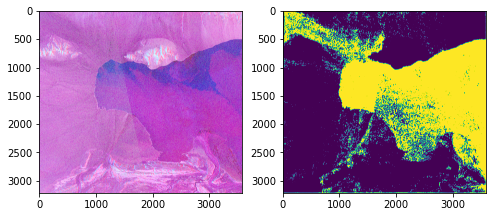

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
imgShow(s1_img_nor)
plt.subplot(1,2,2)
plt.imshow(cla_map)
print(s1_img_nor.shape)
print(cla_map.shape)


#### Visualize the multi-scale patch and the prediction result.

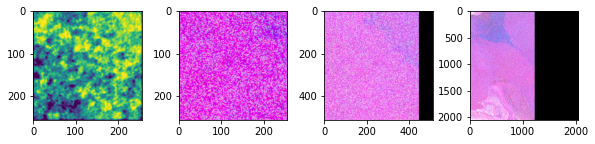

In [17]:
ind = 188
plt.figure(figsize=(10,2))
plt.subplot(1,4,1)
imgShow(pred_patch_list[ind])
plt.subplot(1,4,2)
imgShow(patch_list[ind])
plt.subplot(1,4,3)
imgShow(mid_patch_list[ind])
plt.subplot(1,4,4)
imgShow(higher_patch_list[ind])